In [54]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def get_data_cols(filename):
    file = open(filename, 'r')
    for line in file:
        for item in line.split('\t'):
            return len(item)

def read_data(filename):
    file = open(filename, 'r')
    data_cols = get_data_cols(filename)
    data = []
    counter = 0
    for line in file:
        if len(line.strip()) == 0:
            continue
        row = []
        for item in line.split('\t'):
            row.append(int(item.replace('\n', '')))
        data.append(row)
#         counter += 1
#         if counter == 100: break
    return np.array(data)

In [5]:
train_data = read_data('ticdata2000.txt')

# Câu 1: Mô tả & vẽ đồ thị dữ liệu

Tên tập dữ liệu: Insurance Company Benchmark (COIL 2000)

Link: https://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+%28COIL+2000%29

Số phần tử: 9000

Số thuộc tính: 86

Missing data: không

Task: Classification

### Thông tin về tập dữ liệu

Tập dữ liệu bao gồm thông tin về khách hàng bao gồm 86 thuộc tính bao gồm dữ liệu sản phẩm và dữ liệu nhân khẩu học được trích dựa trên mã zip khu vực. Dữ liệu được cung cấp bởi công ty khai phá dữ liệu Dutch Sentient Machine Research và dựa trên những vấn đề có thực trong kinh doanh.
Mỗi dòng là một phần tử.

TICDATA2000.txt: tập dữ liệu để huấn luyện (5822 khảo sát từ khách hàng). Mỗi dòng gồm 86 thuộc tính, bao gồm dữ liệu về xã hội học (thuộc tính 1-43) và quyền sở hữu sản phẩm. Tất cả khách hàng có cùng mã zip có cùng thuộc tính về xã hội. Thuộc tính 86: CARAVAN: chính sách về số lượng nhà di động là giá trị đích.

TICEVAL2000.txt: tập dữ liệu dùng để dự đoán (4000 khảo sát từ khách hàng) sẽ không có giá trị đích. Ta cần trả về danh sách các dự đoán.

TICTGTS2000.txt: tập dữ liệu để đánh giá độ chính xác

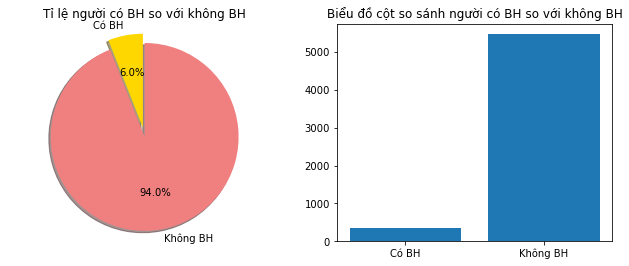

In [31]:
# Lấy cột cuối trong train_data

last_col = train_data[:,-1]
is_have = 0
not_have = 0
total = 0
for row in last_col:
    if row == 1:
        is_have += 1
    elif row == 0:
        not_have += 1
    total += 1
labels = 'Có BH', 'Không BH'
sizes = [is_have, not_have]
colors = ['gold', 'lightcoral']
explode = [0, 0.1]
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels,explode=explode, colors=colors,shadow=True,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Tỉ lệ người có BH so với không BH')

plt.subplot(1,2,2)
plt.bar(labels, sizes)
plt.title('Biểu đồ cột so sánh người có BH so với không BH')
plt.subplots_adjust(left=-0.4, bottom=None, right=1, top=None, wspace=None, hspace=None)

plt.show()

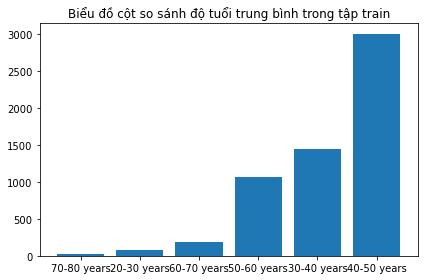

In [45]:
# Lấy cột 3
col = train_data[:,3]
avg_age = defaultdict(dict)
for row in col:
    if row not in avg_age:
        avg_age[row] = 0
    avg_age[row] += 1
temp_avg = defaultdict(dict)
for key, val in avg_age.items():
    if key == 1:
        temp_avg['20-30 years'] = val
    elif key == 2:
        temp_avg['30-40 years'] = val
    elif key == 3:
        temp_avg['40-50 years'] = val
    elif key == 4:
        temp_avg['50-60 years'] = val
    elif key == 5:
        temp_avg['60-70 years'] = val
    elif key == 6:
        temp_avg['70-80 years'] = val
avg_age = dict(sorted(temp_avg.items(), key=lambda item: item[1]))
plt.bar(avg_age.keys(), avg_age.values())
plt.title('Biểu đồ cột so sánh độ tuổi trung bình trong tập train')
plt.tight_layout()
plt.show()

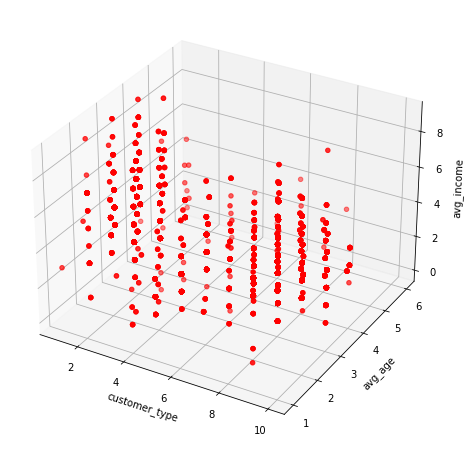

In [62]:
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.set_xlabel('customer_type')
ax.set_ylabel('avg_age')
ax.set_zlabel('avg_income')

customer_type = train_data[:,4]
avg_age = train_data[:,3]
avg_income = train_data[:,41]

ax.scatter(customer_type, avg_age, avg_income,color='r')
fig.set_figheight(8)
fig.set_figwidth(8)

plt.show()

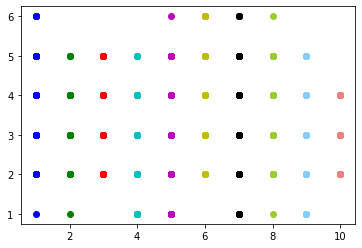

In [98]:
customer_type = train_data[:,4]
avg_age = train_data[:,3]
color_set = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'yellowgreen', 'lightskyblue', 'lightcoral']
for x, y in zip(customer_type, avg_age):
    plt.plot(x, y, color=color_set[x-1], marker='o')
plt.show()

defaultdict(<class 'int'>, {0: 3482, 2: 2128, 1: 201, 3: 11})


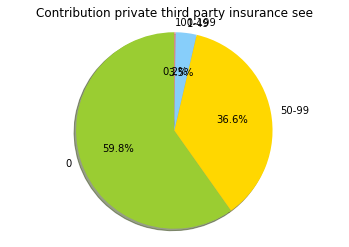

In [116]:
contribution = train_data[:,43]
contribution_set = defaultdict(int)
for row in contribution:
    if row not in contribution_set:
        contribution_set[row] = 0
    contribution_set[row] += 1
print(contribution_set)
labels = '0', '50-99','1-49', '100-199'
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(contribution_set.values(), labels=labels, colors=colors,shadow=True,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Contribution private third party insurance see')
plt.show()

# Câu  2: Chuẩn hóa dữ liệu

In [4]:
def integer_normalize(col):
    col = np.array([col]).T
    minmax = MinMaxScaler()
    col = minmax.fit_transform(col)
    return col

def string_normalize(col):
    encoder = LabelEncoder()
    col = encoder.fit_transform(list(col))
    col = np.array([col]).T
    return col

def normalize_data(data):
    data = data.T
    normalized_data = []
    counter = 0
    for col in data:
        if np.issubdtype(col[0], int):
            col = integer_normalize(col)
        else:
            col = string_normalize(col)
        if isinstance(normalized_data, list):
            normalized_data = col
        else:
            normalized_data = np.concatenate((normalized_data, col), axis = 1)
    return normalized_data

In [31]:
data_model = normalize_data(train_data)
X_model = data_model[:,0:-1]
Y_model = data_model[:,-1]

# Câu 3: Xây dựng mô hình học máy

In [39]:
model_knn = KNeighborsClassifier(n_neighbors = 3)
model_knn.fit(X_model, Y_model)

KNeighborsClassifier(n_neighbors=3)

In [32]:
model_NB = CategoricalNB()
model_NB.fit(X_model, Y_model)

CategoricalNB()

In [25]:
model_svm = svm.SVC(kernel='linear', C=10)
model_svm.fit(X_model, Y_model)

SVC(C=10, kernel='linear')

# Câu 4: Bổ sung 1 mô hình: SVM

In [52]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter = 4000)
clf.fit(X_model, Y_model)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=4000,
              random_state=1, solver='lbfgs')

# Câu 5: Đánh giá độ chính xác

In [33]:
test_data = read_data("ticeval2000.txt")
test_data = normalize_data(test_data)
y_pred = model_NB.predict(test_data)

In [37]:
y_true = read_data("tictgts2000.txt")

In [47]:
print("------------Evaluation kNN model on test set------------")
y_pred = model_knn.predict(test_data)
print("Accuracy on test set = " + str(accuracy_score(y_true, y_pred)))
print("F1-score on test set = " + str(f1_score(y_true, y_pred)))
print(classification_report(y_true, y_pred))

------------Evaluation kNN model on test set------------
Accuracy on test set = 0.934
F1-score on test set = 0.07692307692307693
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3762
           1       0.23      0.05      0.08       238

    accuracy                           0.93      4000
   macro avg       0.59      0.52      0.52      4000
weighted avg       0.90      0.93      0.91      4000



In [48]:
print("------------Evaluation NB model on test set------------")
y_pred = model_NB.predict(test_data)
print("Accuracy on test set = " + str(accuracy_score(y_true, y_pred)))
print("F1-score on test set = " + str(f1_score(y_true, y_pred)))
print(classification_report(y_true, y_pred))

------------Evaluation NB model on test set------------
Accuracy on test set = 0.92925
F1-score on test set = 0.05351170568561873
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3762
           1       0.13      0.03      0.05       238

    accuracy                           0.93      4000
   macro avg       0.54      0.51      0.51      4000
weighted avg       0.89      0.93      0.91      4000



In [63]:
print("------------Evaluation SVM model on test set------------")
y_pred = clf.predict(test_data)
print("Accuracy on test set = " + str(accuracy_score(y_true, y_pred)))
print("F1-score on test set = " + str(f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))))
print(classification_report(y_true, y_pred))

------------Evaluation SVM model on test set------------
Accuracy on test set = 0.9405
F1-score on test set = 0.9693377995362019
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3762
           1       0.00      0.00      0.00       238

    accuracy                           0.94      4000
   macro avg       0.47      0.50      0.48      4000
weighted avg       0.88      0.94      0.91      4000



D:\anacoda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
